In [1]:
import math
import numpy as np
import torch
import torch.nn.functional as F
import torchshow as ts

from typing import Any, Dict

from datasets.shapenet import ShapeNetLoader
from nerfacc.estimators.occ_grid import OccGridEstimator
from radiance_fields.ngp import NGPRadianceField
from radiance_fields.ngp_single_mlp import NGPRadianceFieldSingleMlp
from utils import render_image_with_occgrid_test

In [2]:
device = "cuda:0"

data_root = "/media/data7/fballerini/datasets/shapenet_render"

id = "02958343/1c53bc6a3992b0843677ee89898ae463"

# scene parameters
aabb = torch.tensor([-0.7, -0.7, -0.7, 0.7, 0.7, 0.7], device=device)
near_plane = 0.0
far_plane = 1.0e10
# model parameters
grid_resolution = 128
grid_nlvl = 1
# render parameters
render_n_samples = 1024
render_step_size = (
    (aabb[3:] - aabb[:3]).max() * math.sqrt(3) / render_n_samples
).item()
alpha_thre = 0.0
cone_angle = 0.0

train_dataset = ShapeNetLoader(
    subject_id=id,
    root_fp=data_root,
    split="train",
    num_rays=None,
    device=device
)

estimator = OccGridEstimator(
    roi_aabb=aabb, 
    resolution=grid_resolution, 
    levels=grid_nlvl
).to(device)

radiance_field = None

In [3]:
def render(sd: Dict[str, Any], index: int = 32) -> float:
    estimator.load_state_dict(sd["estimator"], strict=False)
    radiance_field.load_state_dict(sd["radiance_field"])

    # evaluation
    radiance_field.eval()
    estimator.eval()

    with torch.no_grad():
        data = train_dataset[index]
        render_bkgd = data["color_bkgd"]
        rays = data["rays"]
        pixels = data["pixels"]

        # rendering
        rgb, _, _, _ = render_image_with_occgrid_test(
            render_n_samples,
            # scene
            radiance_field,
            estimator,
            rays,
            # rendering options
            near_plane=near_plane,
            far_plane=far_plane,
            render_step_size=render_step_size,
            render_bkgd=render_bkgd,
            cone_angle=cone_angle,
            alpha_thre=alpha_thre,
        )
        mse = F.mse_loss(rgb, pixels)
        psnr = -10.0 * torch.log(mse) / np.log(10.0)
        
        ts.show(rgb)
        return psnr.item()

# Vanilla
$V$ is a single voxel grid of dimensions $32 \times 32 \times 32 \times 4$

In [ ]:
radiance_field = NGPRadianceFieldSingleMlp(
    aabb=estimator.aabbs[-1],
    use_viewdirs=False,
    base_resolution=32,
    n_levels=1,
    n_features_per_level=4,
    encoding_type="torch",
    mlp_activation="Sine",
    n_neurons=64,
    n_hidden_layers=3
).to(device)

sd_path = "ckpts/torch_sine_single_1_4_32/shapenet/02958343/1c53bc6a3992b0843677ee89898ae463"

## $(V_A,M_A)$

34.122589111328125

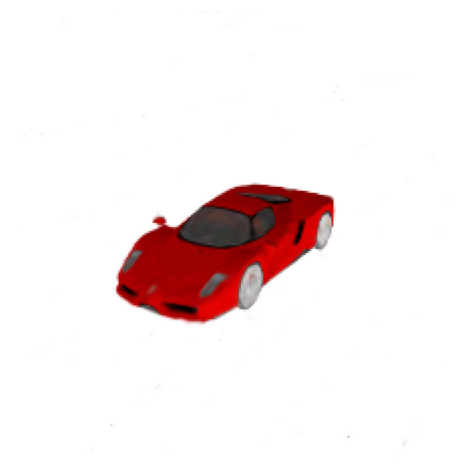

In [11]:
sd_A = torch.load(f"{sd_path}_A.pt")
# del sd_A["estimator"]["occs"]

render(sd_A)

## $(V_A,M_B)$

12.548927307128906

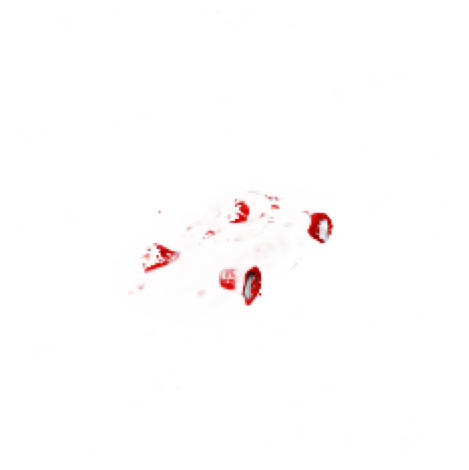

In [12]:
sd_A = torch.load(f"{sd_path}_A.pt")
sd_B = torch.load(f"{sd_path}_B.pt")
sd_A["radiance_field"]["mlp.params"] = sd_B["radiance_field"]["mlp.params"]

render(sd_A)

## $(V_A^\text{perm},M_B)$

15.184886932373047

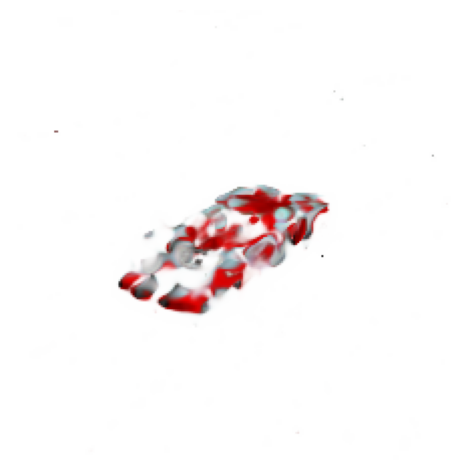

In [13]:
sd = torch.load(f"{sd_path}_perm.pt")

render(sd)

# Multi-resolution
$V$ is made of 3 voxel grids of dimensions:
- $16 \times 16 \times 16 \times 4$
- $32 \times 32 \times 32 \times 4$
- $64 \times 64 \times 64 \times 4$

In [4]:
radiance_field = NGPRadianceFieldSingleMlp(
    aabb=estimator.aabbs[-1],
    use_viewdirs=False,
    base_resolution=16,
    max_resolution=65,
    n_levels=3,
    n_features_per_level=4,
    encoding_type="torch",
    mlp_activation="Sine",
    n_neurons=64,
    n_hidden_layers=3
).to(device)

sd_path = "ckpts/torch_sine_single_3_4_16/shapenet/02958343/1c53bc6a3992b0843677ee89898ae463"

## $(V_A,M_A)$

38.159759521484375

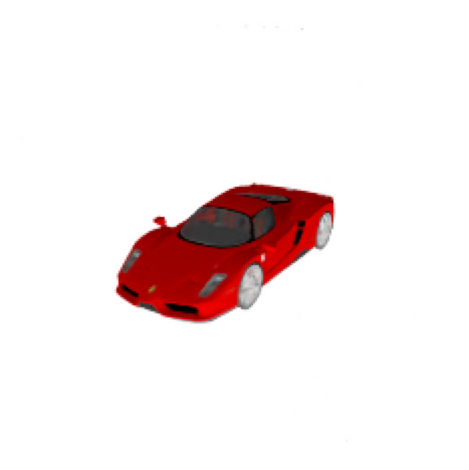

In [5]:
sd_A = torch.load(f"{sd_path}_A.pt")

render(sd_A)

## $(V_A,M_B)$

12.527069091796875

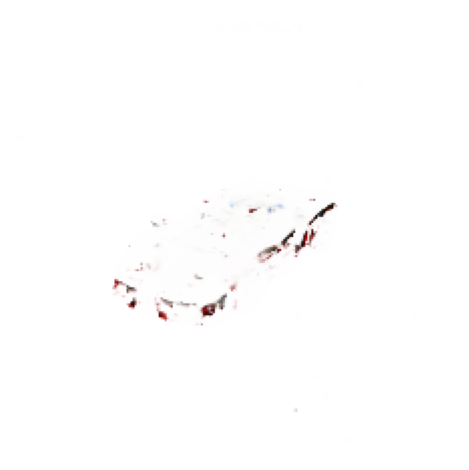

In [6]:
sd_A = torch.load(f"{sd_path}_A.pt")
sd_B = torch.load(f"{sd_path}_B.pt")
sd_A["radiance_field"]["mlp.params"] = sd_B["radiance_field"]["mlp.params"]

render(sd_A)

## $(V_A^\text{perm},M_B)$

18.960128784179688

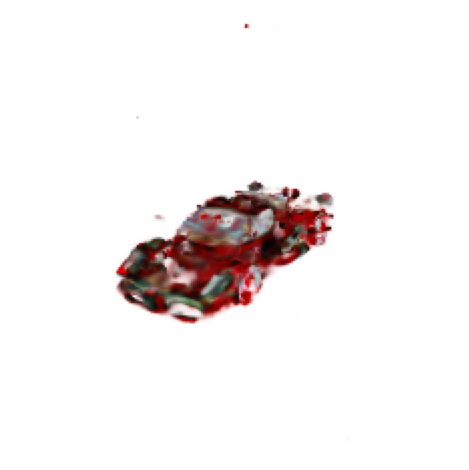

In [7]:
sd = torch.load(f"{sd_path}_perm.pt")

render(sd)

# Collisions
$V$ is made of 4 voxel grids of dimensions:
- $16 \times 16 \times 16 \times 4$
- $32 \times 32 \times 32 \times 4$
- $64 \times 64 \times 64 \times 4$
- $128 \times 128 \times 128 \times 4 \,\leftarrow$ collisions

In [4]:
radiance_field = NGPRadianceFieldSingleMlp(
    aabb=estimator.aabbs[-1],
    use_viewdirs=False,
    base_resolution=16,
    max_resolution=128,
    n_levels=4,
    n_features_per_level=4,
    encoding_type="torch",
    mlp_activation="Sine",
    n_neurons=64,
    n_hidden_layers=3
).to(device)

sd_path = "ckpts/torch_sine_single_4_4_16/shapenet/02958343/1c53bc6a3992b0843677ee89898ae463"

## $(V_A,M_A)$

40.81942367553711

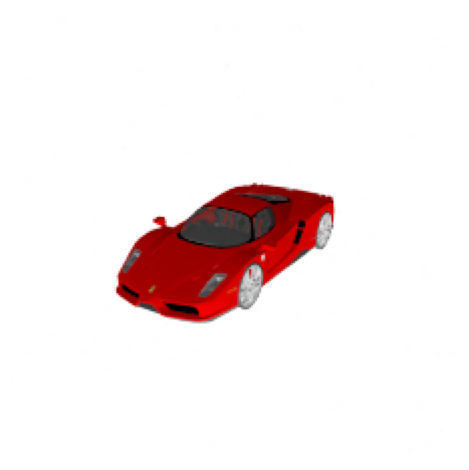

In [5]:
sd_A = torch.load(f"{sd_path}_A.pt")

render(sd_A)

## $(V_A,M_B)$

14.97238826751709

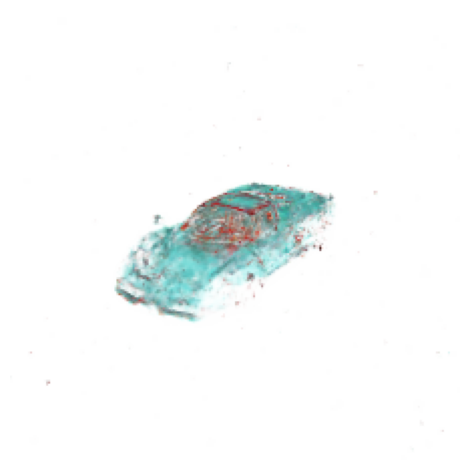

In [6]:
sd_A = torch.load(f"{sd_path}_A.pt")
sd_B = torch.load(f"{sd_path}_B.pt")
sd_A["radiance_field"]["mlp.params"] = sd_B["radiance_field"]["mlp.params"]

render(sd_A)

## $(V_A^\text{perm},M_B)$

25.582916259765625

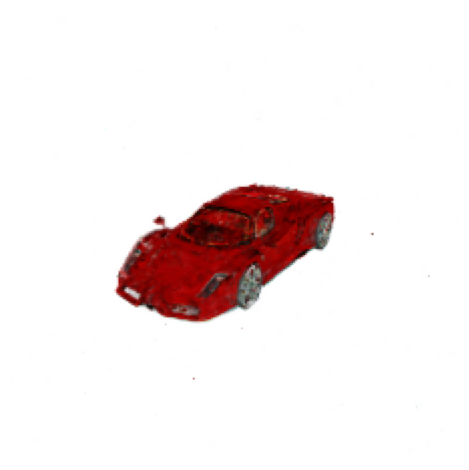

In [5]:
sd = torch.load(f"{sd_path}_perm.pt")

render(sd)

# Instant-NGP

In [6]:
radiance_field = NGPRadianceField(
    aabb=estimator.aabbs[-1],
    encoding_type="torch"
).to(device)

sd_path = "ckpts/torch_relu/shapenet/02958343/1c53bc6a3992b0843677ee89898ae463"

## $(H_A,M_A)$

50.228519439697266

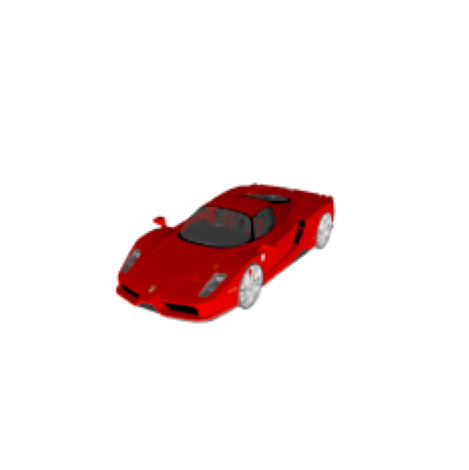

In [9]:
sd_A = torch.load(f"{sd_path}_A.pt")

render(sd_A)

## $(H_A,M_B)$

15.611882209777832

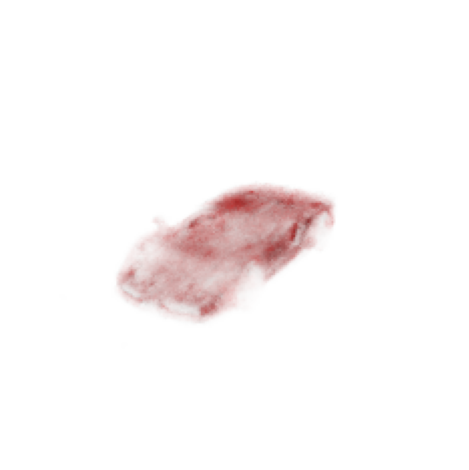

In [10]:
sd_A = torch.load(f"{sd_path}_A.pt")
sd_B = torch.load(f"{sd_path}_B.pt")
sd_A["radiance_field"]["mlp_base.1.params"] = sd_B["radiance_field"]["mlp_base.1.params"]  # density mlp
sd_A["radiance_field"]["mlp_head.params"] = sd_B["radiance_field"]["mlp_head.params"]  # color mlp

render(sd_A)

## $(H_A^\text{perm},M_B)$

16.7064151763916

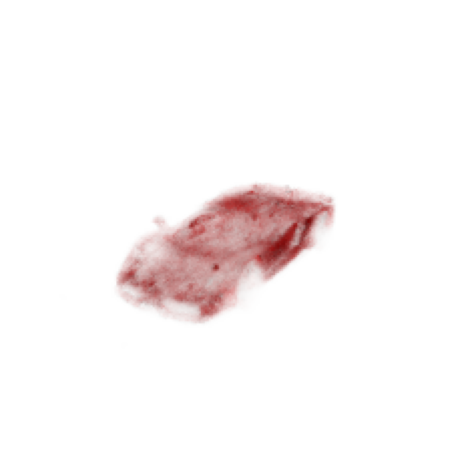

In [7]:
sd = torch.load(f"{sd_path}_perm.pt")

render(sd)

# Summary

|| Vanilla | Multi-res | Collisions | Instant |
|-|-:|-:|-:|-:|
$(A,A)$ | 34.1 | 38.2 | 40.8 | 50.2 |
$(A,B)$ | 12.5 | 12.5 | 15.0 | 15.6 |
$(A^\text{perm},B)$ | 15.2 | 19.0 | 25.6 | 16.7 |